# Experiment 2
Adjust the size of dataset (valid set) to see what happens to the performance of various calibration models

In [1]:
import sys
# enable importing the modules from probcalkge
sys.path.append('../')
sys.path.append('../probcalkge')

In [2]:
import importlib
from pprint import pprint
import numpy as np
import pandas as pd
from typing import Iterable

In [3]:
from probcalkge import Experiment, DatasetWrapper, ExperimentResult
from probcalkge import get_datasets, get_calibrators, get_kgemodels
from probcalkge import brier_score, negative_log_loss, ks_error, ece, accuracy

In [4]:
from probcalkge.calmodels2 import get_calibrators
ds = get_datasets()
cals = get_calibrators()
kges = get_kgemodels()

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


In [5]:
def dataset_stats(ds: Iterable[DatasetWrapper]) -> pd.DataFrame:
    vals = []
    rows = []
    cols = ['train', 'valid', 'test', 'entities', 'relations']
    for i in ds:
        rows.append(i.name)
        vals.append(i.stats)
    return pd.DataFrame(vals, index=rows, columns=cols)

In [6]:
df = dataset_stats(ds)
print(df.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &   train &   valid &    test &  entities &  relations \\
\midrule
FB13k      &  316232 &   11816 &   47464 &     75043 &         13 \\
WN11       &  110361 &    4877 &   19706 &     38194 &         11 \\
YAGO39     &  354994 &   18471 &   18507 &     37612 &         37 \\
DBpedia50  &   32388 &     246 &    4196 &     24624 &        351 \\
UMLS       &    5216 &    1304 &    1322 &       135 &         46 \\
Kinship    &    8544 &    2136 &    2148 &       104 &         25 \\
Nations    &    1592 &     398 &     402 &        14 &         55 \\
YAGO\_ET    &  364810 &   50194 &   49268 &     26957 &         64 \\
DBpedia\_ET &  653188 &  104776 &  104900 &     99240 &        316 \\
\bottomrule
\end{tabular}



In [7]:
import random
from probcalkge import DatasetWrapper

def shrink_dataset(ds: DatasetWrapper, perc=0.5) -> DatasetWrapper:
    '''
    Shrink the size of dataset training samples by randon sampling
    '''
    new_X_train = random.sample(ds.X_train.tolist(), int(perc * len(ds.X_train)))
    new_X_train = np.array(new_X_train)
    new_X_ents = set(new_X_train[:, 0]).union(set(new_X_train[:, 2]))
    new_X_rels = set(new_X_train[:, 1])

    new_X_valid, new_y_valid = [], []
    for X, y in zip(ds.X_valid, ds.y_valid):
        if X[0] in new_X_ents and X[2] in new_X_ents and X[1] in new_X_rels:
            new_X_valid.append(X.tolist())
            new_y_valid.append(y)
    new_X_valid, new_y_valid = np.array(new_X_valid), np.array(new_y_valid)
    
    new_X_test, new_y_test = [], []
    for X, y in zip(ds.X_test, ds.y_test):
        if X[0] in new_X_ents and X[2] in new_X_ents and X[1] in new_X_rels:
            new_X_test.append(X.tolist())
            new_y_test.append(y)
    new_X_test, new_y_test = np.array(new_X_test), np.array(new_y_test)

    return DatasetWrapper(f'{ds.name}',
                            new_X_train,
                            new_X_valid, new_y_valid,
                            new_X_test, new_y_test
    )

def shrink_valid(ds: DatasetWrapper, perc=0.5) -> DatasetWrapper:
    valids = np.hstack([ds.X_valid, ds.y_valid.reshape([-1, 1])])
    new_valids = np.array(random.sample(valids.tolist(), int(perc * len(valids))))
    return DatasetWrapper(f'{ds.name}',
                            ds.X_train,
                            new_valids[:, :3], new_valids[:, 3].astype(int),
                            ds.X_test, ds.y_test
    )


In [8]:
exp = Experiment(
    cals=[cals.uncal, cals.platt, cals.isot, cals.beta, cals.histbin], 
    datasets=[ds.fb13, ds.wn18, ds.yago39], 
    kges=[kges.transE, kges.complEx, kges.distMult, kges.hoLE], 
    metrics=[brier_score, negative_log_loss, ece]
)

exp.load_trained_kges('../saved_models/trained_kges')

exp_reses = []

scales = np.array([1.0, 0.7, 0.4, 0.1, 0.05, 0.01])

for i in scales:
    new_fb = shrink_valid(ds.fb13, perc=i)
    new_wn = shrink_valid(ds.wn18, perc=i)
    new_yg = shrink_valid(ds.yago39, perc=i) 
    
    exp.datasets = [new_fb, new_wn, new_yg]
    
    exp_res = exp.run_with_trained_kges()
    exp_reses.append(exp_res)


Loaded trained KG embedding models.
training various calibrators for TransE on FB13k ...
training various calibrators for ComplEx on FB13k ...
training various calibrators for DistMult on FB13k ...
training various calibrators for HolE on FB13k ...
training various calibrators for TransE on WN11 ...
training various calibrators for ComplEx on WN11 ...
training various calibrators for DistMult on WN11 ...
training various calibrators for HolE on WN11 ...
training various calibrators for TransE on YAGO39 ...
training various calibrators for ComplEx on YAGO39 ...
training various calibrators for DistMult on YAGO39 ...
training various calibrators for HolE on YAGO39 ...
training various calibrators for TransE on FB13k ...
training various calibrators for ComplEx on FB13k ...
training various calibrators for DistMult on FB13k ...
training various calibrators for HolE on FB13k ...
training various calibrators for TransE on WN11 ...
training various calibrators for ComplEx on WN11 ...
trainin

In [9]:
def res_pivot(exp_res: ExperimentResult) -> pd.DataFrame:
    newdf = exp_res.to_frame().pivot_table(values='ExpRes', index=['dataset', 'kge', 'metric'], columns=['cal'])
    newdf['avg_excl_uncal'] = newdf.loc[:, newdf.columns != 'UncalCalibrator'].mean(axis=1)
    return newdf

In [10]:
lst_counts = []
for res in exp_reses:
    counts = res_pivot(res).idxmax(axis=1).value_counts()
    lst_counts.append(counts)
various_counts = pd.DataFrame(lst_counts,  columns=counts.index, index=scales.astype(str))
various_counts['UncalCalibrator'] = pd.Series([0]*len(scales), index=scales.astype(str))
lgds = ['UncalCalibrator', 'PlattCalibrator', 'IsotonicCalibrator', 
        'BetaCalibrator', 'HistogramBinningCalibrator', ]
various_counts = various_counts.reindex(columns=lgds).fillna(0)

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100 # default for me was 75
plt.rc('figure', titlesize=10)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=7)
plt.rc('lines', linewidth=2)
plt.rc('lines', markersize=2)

<AxesSubplot:>

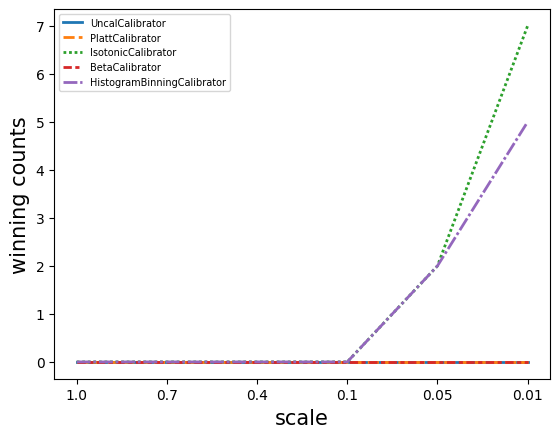

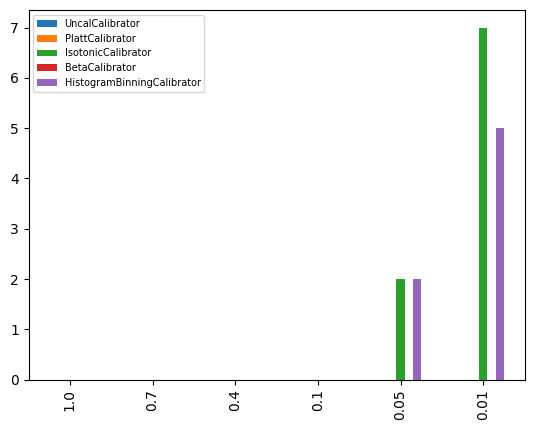

In [12]:
import seaborn as sns
ax = sns.lineplot(data=various_counts, sort=False)
ax.set(xlabel='scale', ylabel='winning counts')
various_counts.plot(kind='bar')

In [13]:
lst_counts = []
for res in exp_reses:
    counts = res_pivot(res).xs('negative_log_loss', axis=0, level=2, drop_level=False).idxmin(axis=1).value_counts()
    lst_counts.append(counts)
various_counts = pd.DataFrame(lst_counts,  columns=counts.index, index=scales.astype(str))
various_counts['UncalCalibrator'] = pd.Series([0]*len(scales), index=scales.astype(str))
lgds = ['UncalCalibrator', 'PlattCalibrator', 'IsotonicCalibrator', 
        'BetaCalibrator', 'HistogramBinningCalibrator', ]
various_counts = various_counts.reindex(columns=lgds).fillna(0)

<AxesSubplot:>

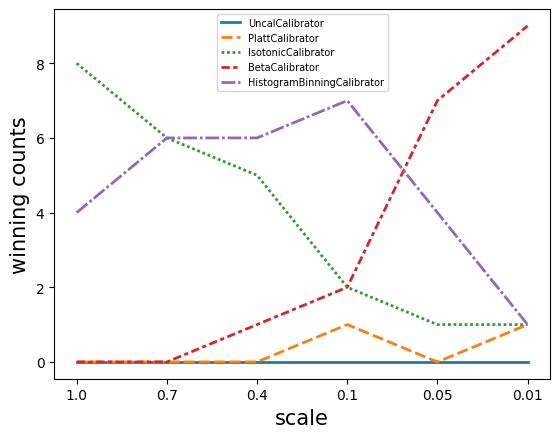

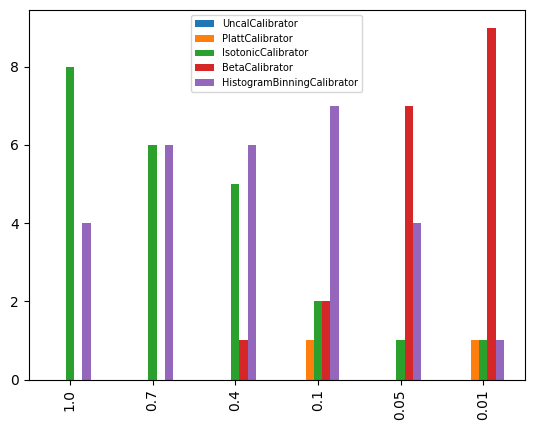

In [14]:
import seaborn as sns
ax = sns.lineplot(data=various_counts, sort=False)
ax.set(xlabel='scale', ylabel='winning counts')
various_counts.plot(kind='bar')

In [15]:
lst_counts = []
for res in exp_reses:
    counts = res_pivot(res).xs('accuracy', axis=0, level=2, drop_level=False).idxmax(axis=1).value_counts()
    lst_counts.append(counts)
various_counts = pd.DataFrame(lst_counts,  columns=counts.index, index=scales.astype(str))
various_counts['UncalCalibrator'] = pd.Series([0]*len(scales), index=scales.astype(str))
lgds = ['UncalCalibrator', 'PlattCalibrator', 'IsotonicCalibrator', 
        'BetaCalibrator', 'HistogramBinningCalibrator', ]
various_counts = various_counts.reindex(columns=lgds).fillna(0)

KeyError: 'accuracy'

<AxesSubplot:xlabel='dataset,kge,cal,metric'>

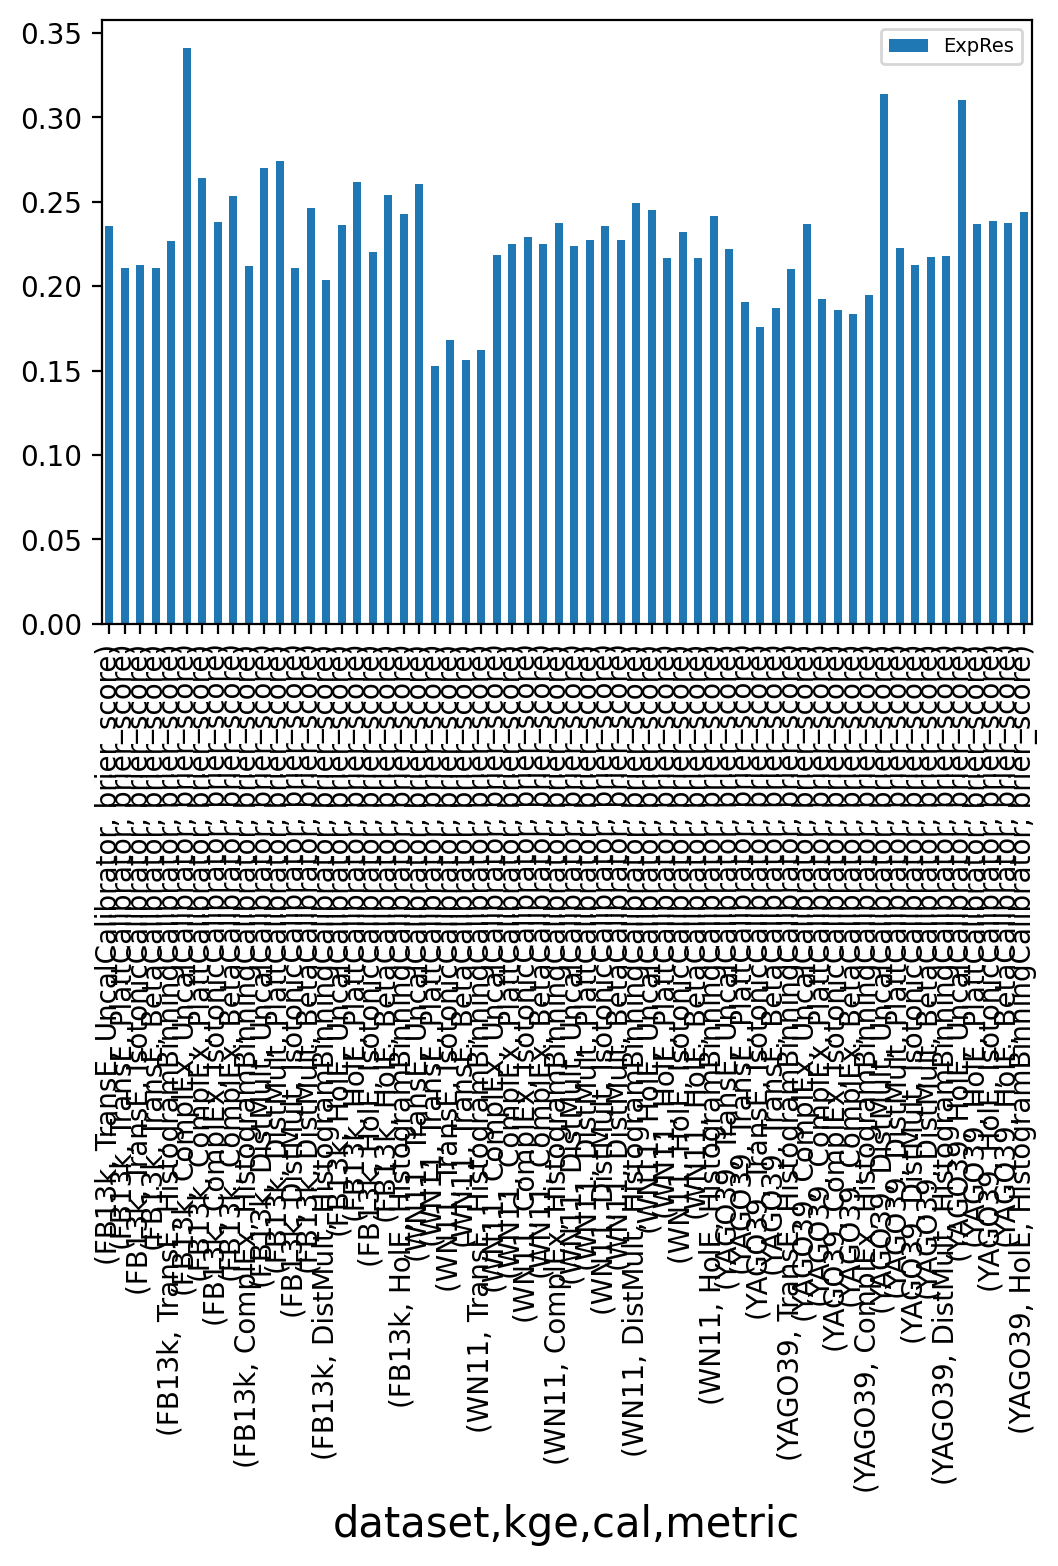

In [ ]:
plt.rc('figure', dpi=200) 
exp_reses[-1].to_frame().xs('brier_score', axis=0, level=3, drop_level=False).plot(kind='bar')